In [490]:
# A trivial discrete random cellular automaton epidemy model. I wrote it for demonstration purposes only.
# Decrease total_population to run faster. Increase total_population to have smoother output.
#
#    Copyright (C) 2020  S. Shelyag
#
#    This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.

#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.

#    You should have received a copy of the GNU General Public License
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [491]:
# Importing usual stuff
import matplotlib.pyplot as plt
import numpy as np
import time
np.random.seed(int(time.time()))

In [492]:
# Here we do a few supplementary functions
# We need distribution of ages in population - upside-down logistic function
def age_distribution(x):
    return(1.0-1.0/(1.0+np.exp(-0.3*(x-70.0))))

# We need the probability to die, also logistic function
def probability_to_die_on_age(x):
    return(1.0/(1.0+np.exp(-0.1*(x-60.0))))

# We need the incubation period, assume normal distribution around mean_incubation_period.
# Sigma is spread.
# We will also cut the tails at min_cut and max_cut.
def incub_period(mean_incubation_period, spread, min_cut, max_cut):
    while (True):
        x = np.random.normal(mean_incubation_period,spread)
        if (x > min_cut) & (x < max_cut):
            return(x)

# And a supplementary function to generate array of those
def incubation_period_sample(mean_incubation_period, spread, min_cut, max_cut, nsample):
    samples = []
    i = 0
    while (i < nsample):
        samples += [int(incub_period(mean_incubation_period, spread, min_cut, max_cut))]
        i=i+1
    return(samples)
        
    
def recov_period(persons_age, mean_recovery_period, recovery_sigma, min_cut, max_cut):
    #we assume, the older, the longer it is to recover
    while (True):
        x = np.random.normal(mean_recovery_period + persons_age / 10.0, recovery_sigma)
        if (x > min_cut) & (x < max_cut):
            return(x)
    
    
# Here function to compute recovery period is dependent on age, so a little different from others.  
def recovery_period_sample(age, mean_recovery_period, recovery_sigma, min_cut, max_cut, nsample):
    samples = []
    i = 0
    for persons_age in age:
        samples += [int(recov_period(persons_age, mean_recovery_period, recovery_sigma, min_cut, max_cut))]
    return(samples)

        
# Finally, we need a routine to generate a random number with a given distribution function
def random_dist(x_low,x_high,distribution):
    while (True):
        x=np.random.uniform(low=x_low,high=x_high)
        prop=distribution(x)
        if np.random.uniform(low=0,high=1) <=prop:
            return x
        
# and a supplementary function to generate array of those
def random_dist_sample(x_low, x_high, nsample, distribution):
    samples = []
    i = 0
    while (i < nsample):
        samples += [random_dist(x_low,x_high,distribution)]
        i=i+1
    return(samples)

In [493]:
# In this section we will define the parameters of the model.
# We still will be doing a discrete-type model, a cellular automaton.
# First of all, we need to model large, but finite population.
# We will model it directly through a numpy array, where each cell of the array will be
# a single person. In this instance, our population will be uniform - there will be 
# no communities or families whatsoever.
total_population = 10000 #total population
# also, each human will have a status, which is a value in the corresponding cell. 
# Let's assume the following statuses:
healthy = 0 # 0 - human not previously infected, not currently infected
infected_not_spreader = 1 # 1 - human currently infected, not spreading infection (within incubation period)
infected_spreader = 2 # 2 - human currently infected, spreading infection (after incubation period)
recovered_immune = 3 # 3 - human recovered with immunity
recovered_not_immune = 4 # 4 - human recovered without immunity
not_recovered = 5 # 5 - human died
# it is nice and convenient, as we will be able to compute totals for each of the
# sub-populations and plot them in different colours.
#
# As before, we simulate our population for a number of days and start from day 1
number_of_days = 300
# We also define an incubation period:
mean_incubation_period = 5 #days
# And incubation period delta
incubation_sigma = 2 #days
# and the probability to infect in contact
probability_to_infect = 0.2
# maximum probability do die during each day of being infected spreader
probability_to_die_constant = 0.005
# recovery length - if we manage not to die in 14 days, we recover, either with immunity, or without
mean_recovery_period = 14 #days
# delta recovery period; minimum length is recovery_period, max length is recovery_period + delta_rec...
recovery_sigma = 1 #days 
# probability not to get immune
probability_not_to_get_immune = 0.1


In [494]:
# Arrays with humans
# Initially, the population is completely clean of infection (np.zeros, healthy = 0)
humans = np.zeros(total_population)
# Also, we create an array which will show when - which day - a particular human
# was infected:
infected_date = np.zeros(total_population)
# We also need other properties of population, such as age:
age = np.array(random_dist_sample(0,100,total_population,distribution = age_distribution))
# Probability to die from infection, given age
probability_to_die = probability_to_die_constant * probability_to_die_on_age(age)
# Incubation period for each person
incubation_period = incubation_period_sample(mean_incubation_period, incubation_sigma, 0, 20, total_population)
# Recovery period for each person. We can make it dependent on age.
recovery_period = recovery_period_sample(age, mean_recovery_period, recovery_sigma, 2, 20, total_population)
# We will need output. We are interested in how the numbers evolve. Also,
# we put here initial values for consistency.
healthy_total = np.array([total_population-1])
infected_not_spreader_total = np.array([1])
infected_spreader_total = np.array([0])
recovered_immune_total = np.array([0])
recovered_not_immune_total = np.array([0])
not_recovered_total = np.array([0])
#
#
#
current_day = 1
# we introduce a single infected human.
humans[0] = infected_spreader
infected_date[0] = 0

# Now we start our temporal loop:
while (current_day < number_of_days):
    # what we need is the infection spread model now.
    # Let's define the rules. 
    #
    # Rule 1:
    #
    # A human can get infected if not previously infected or previously infected not immune.
    # The probability to get infected increases with the number of infected people around.
    # First of all, we need to get the list of people currently infectable:
    infectable_list = np.ravel(np.where((humans == healthy) | (humans == recovered_not_immune))) #see statuses
    # Now we need to find those who can infect:
    spreaders_list = np.ravel(np.where(humans == infected_spreader))
    # Note at this point it is possible to introduce geometry into the problem.
    # We could assign locations and communities for spreaders_list and for infectable_list, 
    # and then define the probabilities to infect based on those.
    # We are not going to do it now. We will just randomly infect - also, this is the most
    # unoptimal, the slowest way to do it - but didactic.
    if (np.size(infectable_list) != 0):
        for spreader in spreaders_list:
            p = np.random.random()
            if (p < probability_to_infect) & (np.size(infectable_list) != 0): #note how it is used here
                # we infect only one person and aim for not infected. Replace '1' with larger number.
                ##who_will_be_infected_index = np.random.choice(np.arange(np.size(infectable_list)), 2)
                ##who_will_be_infected = infectable_list[who_will_be_infected_index]
                # and we turn this human into infected one
                ##humans[who_will_be_infected] = infected_not_spreader # currently infected, but not spreader
                ##infected_date[who_will_be_infected] = current_day # assign the infection date
                # Here, it is possible to get infected from multiple spreaders.
                # It means, spreaders are not actively seeking non-infected (not zombie-like).
                # To change this, uncomment (although it does not change much):
                # infectable_list = np.delete(infectable_list, who_will_be_infected_index)
                #
                # Or we can do it in a different way - purely random meeting:
                who_will_be_infected = np.random.choice(np.arange(total_population), 1)
                if ((humans[who_will_be_infected] == healthy) | (humans[who_will_be_infected] == recovered_not_immune)):
                    humans[who_will_be_infected] = infected_not_spreader # currently infected, but not spreader
                    infected_date[who_will_be_infected] = current_day # assign the infection date    
                
                
          
    #
    # Rule 2:
    # A human who is infected, but not spreader, becomes spreader after incubation period
    for index, human in enumerate(humans):
        if (human == infected_not_spreader):
            # if incubation_period passed
            infected_becomes_active = infected_date[index] + incubation_period[index]
            if (infected_becomes_active == current_day):
                humans[index] = infected_spreader
                
    #
    # Rule 3:
    # A human who is infected spreader, can die with probability_to_die
    # Limited capacity of hospitals can be introduced here.
    # For example, if number of infected active is greater than 10% of
    # population, we increase the probability by factor of 2.
    hospital_load_factor = (np.sum(humans == infected_spreader) / total_population) > 0.1
    for index, human in enumerate(humans):
        if (human == infected_spreader):
            p = np.random.random()
            if (p < probability_to_die[index] * (1.0 + 3.0 * hospital_load_factor)):
                humans[index] = not_recovered
                
    #
    # Rule 4:
    # A human who is infected and survives for 14 days, recovers.
    # Also, there is a chance that after survival, the human does not get immunity.
    for index, human in enumerate(humans):
        if (human == infected_spreader):
            if (infected_date[index] + recovery_period[index] == current_day):
                p = np.random.random()
                if (p < probability_not_to_get_immune):
                    humans[index] = recovered_not_immune
                else:
                    humans[index] = recovered_immune

                    
                    
    # Now we need to collect some statistics                
    healthy_total = np.append(healthy_total, np.sum(humans == healthy))
    infected_not_spreader_total = np.append(infected_not_spreader_total, np.sum(humans == infected_not_spreader))
    infected_spreader_total = np.append(infected_spreader_total, np.sum(humans == infected_spreader))
    recovered_immune_total = np.append(recovered_immune_total, np.sum(humans == recovered_immune))
    recovered_not_immune_total = np.append(recovered_not_immune_total, np.sum(humans == recovered_not_immune))
    not_recovered_total = np.append(not_recovered_total, np.sum(humans == not_recovered))
        
       
                    
    # And we go for the next day
    current_day = current_day + 1


Text(0.5, 1.0, 'Distribution of initial population by age')

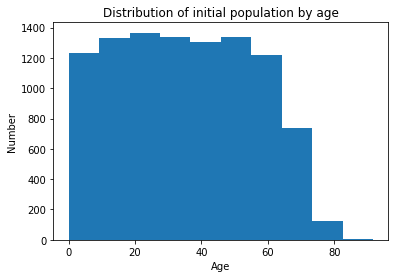

In [495]:
# Let's look at the generated population first.
# Fewer older people is how we generate it.
plt.hist(age)
plt.xlabel('Age')
plt.ylabel('Number')
plt.title('Distribution of initial population by age')

Text(0.5, 1.0, 'Incubation period distribution')

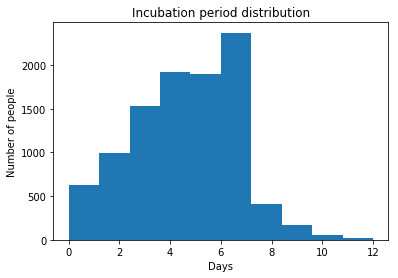

In [496]:
# Incubation period distribution
plt.hist(incubation_period)
plt.xlabel('Days')
plt.ylabel('Number of people')
plt.title('Incubation period distribution')

Text(0.5, 1.0, 'Recovery period on age')

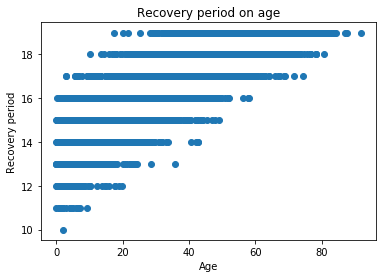

In [497]:
# Recovery period should depend on age.
plt.scatter(age,recovery_period)
plt.xlabel('Age')
plt.ylabel('Recovery period')
plt.title('Recovery period on age')

Text(0, 0.5, 'Number of dead')

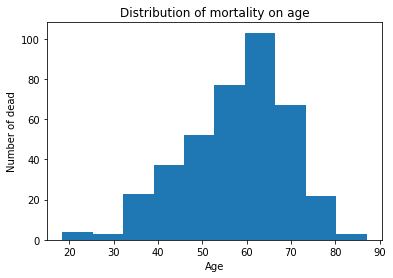

In [498]:
# Let's look at the age-related statistics.
plt.hist(age[np.where(humans == not_recovered)])
plt.title("Distribution of mortality on age")
plt.xlabel("Age")
plt.ylabel("Number of dead")
# You can see an interesting effect of epidemy on the population.
# Although the mortality strongly increases with age, the main mortality component is around 50-60 years.

Text(0, 0.5, 'Number of survived')

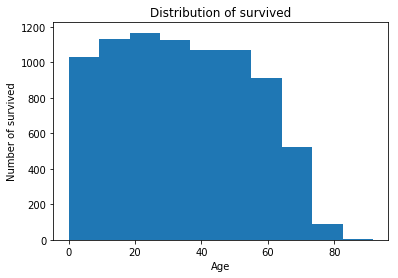

In [499]:
plt.hist(age[np.where(humans == recovered_immune)])
plt.title("Distribution of survived")
plt.xlabel("Age")
plt.ylabel("Number of survived")
# This is expected.

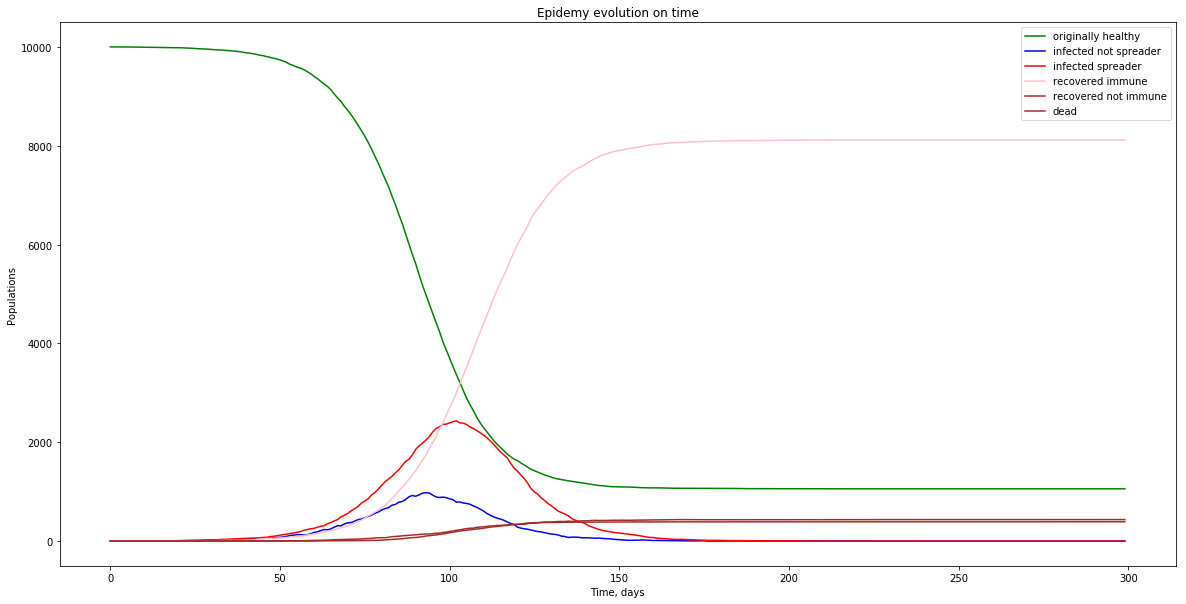

In [500]:
#time to plot things.
time_axis = np.arange(number_of_days)
plt.figure(figsize=(20,10))
plt.plot(time_axis, healthy_total,color='green',label='originally healthy')
plt.plot(time_axis, infected_not_spreader_total,color='blue',label='infected not spreader')
plt.plot(time_axis, infected_spreader_total,color='red',label='infected spreader')
plt.plot(time_axis, recovered_immune_total,color='pink',label='recovered immune')
plt.plot(time_axis, recovered_not_immune_total,color='brown',label='recovered not immune')
plt.plot(time_axis, not_recovered_total,color='brown',label='dead')
plt.xlabel("Time, days")
plt.ylabel("Populations")
plt.title("Epidemy evolution on time")
plt.legend()
# An interesting thing here, and probably not realistic, is the sharp end of the epidemy.
# This is because we defined Rule 4 in a deterministic way. In reality, for some it can take
# longer, for others it can take quicker to recover.
# It can be easily fixed - just uncomment the bit with delta_recovery_period in Rule 4.
# If uncommented, you will see a very long tail.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


0.0391


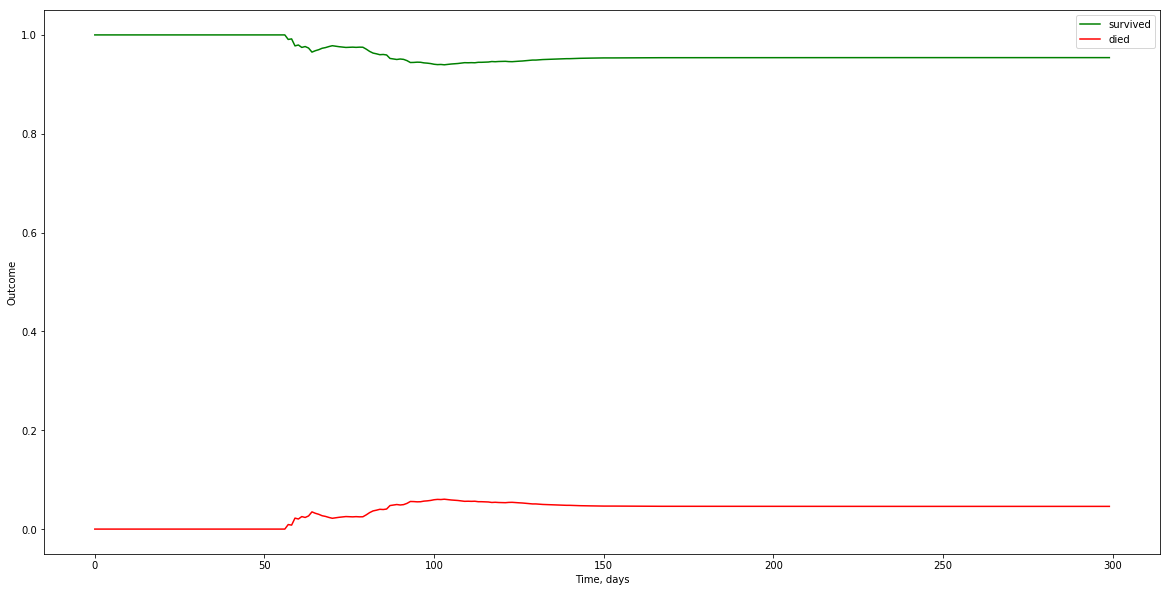

In [501]:
#time to plot things.
time_axis = np.arange(number_of_days)
plt.figure(figsize=(20,10))
t_pop_outcome = recovered_immune_total + not_recovered_total
healthy_pop_outcome = recovered_immune_total / t_pop_outcome
dead_pop_outcome = not_recovered_total / t_pop_outcome

healthy_pop_outcome[np.isnan(healthy_pop_outcome)] = 1
dead_pop_outcome[np.isnan(dead_pop_outcome)] = 0

plt.plot(time_axis, healthy_pop_outcome,color='green',label='survived')
plt.plot(time_axis, dead_pop_outcome, color='red',label='died')
plt.xlabel("Time, days")
plt.ylabel("Outcome")
plt.legend()

print((not_recovered_total / total_population)[-1])

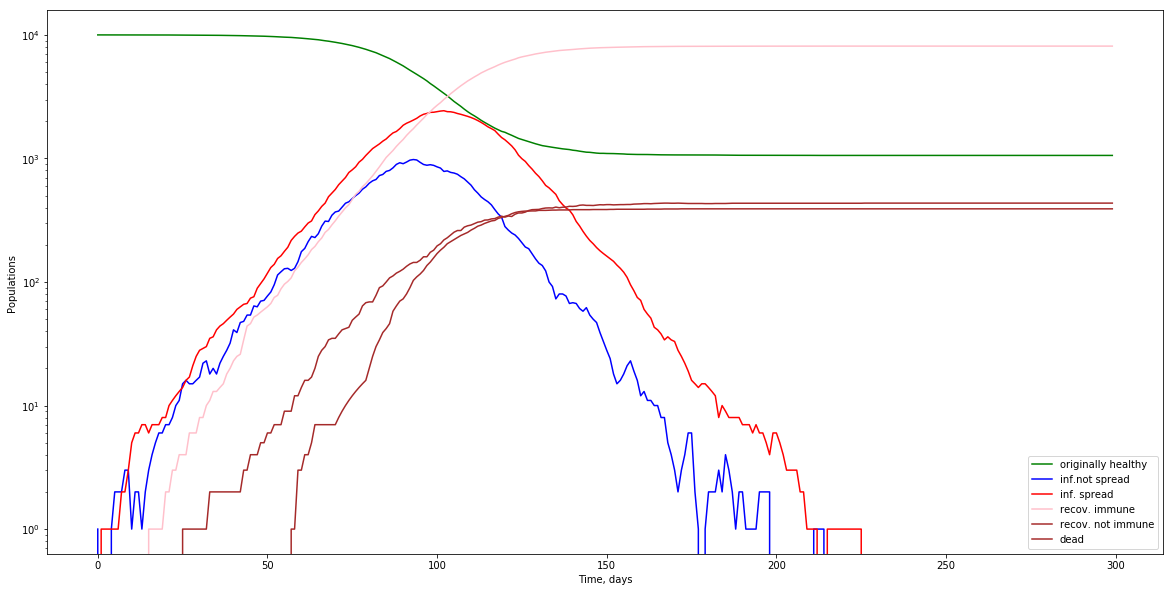

In [502]:
# log plots.
# Note beautibul straight lines and explosive character of evolution.
# Note the wavy pattern. It disappears if the probability to get immunity is very high. These
# oscillations come from reappearance of infected from recovered not immune.
# and you can use plt.yscale to set log vertical axis.
time_axis = np.arange(number_of_days)
plt.figure(figsize=(20,10))
plt.yscale("log")
plt.plot(time_axis, healthy_total,color='green',label='originally healthy')
plt.plot(time_axis, infected_not_spreader_total,color='blue',label='inf.not spread')
plt.plot(time_axis, infected_spreader_total,color='red',label='inf. spread')
plt.plot(time_axis, recovered_immune_total,color='pink',label='recov. immune')
plt.plot(time_axis, recovered_not_immune_total,color='brown',label='recov. not immune')
plt.plot(time_axis, not_recovered_total,color='brown',label='dead')
plt.xlabel("Time, days")
plt.ylabel("Populations")
plt.legend()

In [274]:
print(np.size(infectable_list))

3570


(array([ 557.,  910., 1502., 1931., 2000., 2447.,  430.,  165.,   38.,
          20.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

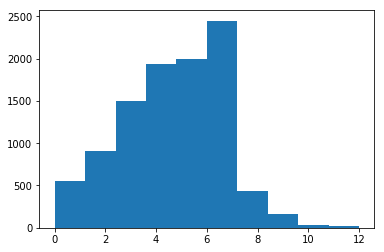

In [275]:
plt.hist(incubation_period)

In [15]:
print(incubation_period)

[9, 6, 8, 8, 8, 4, 6, 4, 7, 7, 10, 4, 8, 8, 9, 7, 5, 6, 11, 8, 6, 6, 8, 9, 6, 13, 7, 7, 7, 9, 9, 8, 8, 5, 8, 10, 10, 7, 7, 10, 6, 7, 10, 8, 9, 7, 9, 9, 11, 10, 10, 10, 8, 8, 10, 6, 8, 6, 12, 6, 8, 9, 8, 6, 8, 10, 7, 9, 7, 8, 8, 7, 9, 7, 8, 8, 6, 6, 10, 7, 9, 10, 8, 9, 8, 8, 7, 6, 9, 8, 8, 9, 5, 9, 8, 6, 10, 8, 5, 10, 6, 7, 6, 7, 7, 9, 8, 7, 6, 7, 9, 6, 6, 5, 7, 11, 10, 6, 8, 7, 6, 2, 8, 8, 10, 7, 5, 10, 8, 8, 7, 8, 8, 8, 10, 8, 9, 5, 8, 6, 6, 12, 3, 8, 4, 9, 10, 5, 10, 9, 6, 8, 7, 6, 6, 7, 6, 11, 11, 7, 4, 6, 7, 10, 9, 8, 9, 3, 8, 9, 9, 5, 6, 13, 10, 3, 8, 6, 6, 5, 8, 8, 4, 9, 8, 10, 8, 6, 7, 3, 8, 9, 9, 6, 12, 3, 9, 8, 11, 7, 7, 6, 5, 9, 7, 4, 12, 9, 7, 7, 8, 4, 7, 9, 10, 8, 4, 6, 9, 7, 9, 11, 6, 8, 9, 11, 8, 6, 7, 4, 9, 8, 6, 6, 3, 12, 7, 7, 4, 8, 9, 8, 6, 6, 10, 8, 8, 9, 10, 8, 7, 5, 6, 11, 8, 2, 7, 8, 6, 8, 10, 12, 7, 7, 5, 9, 9, 6, 6, 7, 10, 7, 8, 7, 7, 11, 7, 8, 6, 9, 9, 7, 8, 9, 5, 7, 9, 9, 7, 6, 6, 10, 5, 6, 8, 4, 10, 10, 6, 5, 11, 3, 7, 9, 8, 8, 6, 5, 6, 7, 5, 5, 6, 10, 10, 5,